In [33]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from os.path import dirname, abspath, join
from os import listdir
from sklearn.model_selection import train_test_split

### Read Data from files

In [34]:
cur_dir = abspath("")
data = pd.DataFrame(columns=['path', 'speaker', 'number'])
data_path = join(cur_dir, 'Audio')
for dir in listdir(data_path):
    number_dir = join(data_path, dir)
    for audio in listdir(number_dir):
        new_data = {'path': join(number_dir, audio), 'speaker': audio.split("_")[1], 'number': int(dir)}
        data = data._append(new_data, ignore_index=True)

data.head()

,path,speaker,number
0,f:\EDU\Data science\Projects\speech_mnist\Audi...,george,0
1,f:\EDU\Data science\Projects\speech_mnist\Audi...,george,0
2,f:\EDU\Data science\Projects\speech_mnist\Audi...,george,0
3,f:\EDU\Data science\Projects\speech_mnist\Audi...,george,0
4,f:\EDU\Data science\Projects\speech_mnist\Audi...,george,0


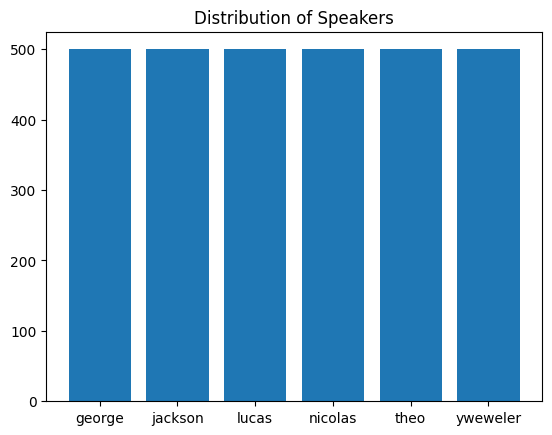

In [29]:
speaker_data = data.groupby(by='speaker')['number'].count()
plt.bar(x=speaker_data.index, height=speaker_data.values)
plt.title("Distribution of Speakers")
plt.show()

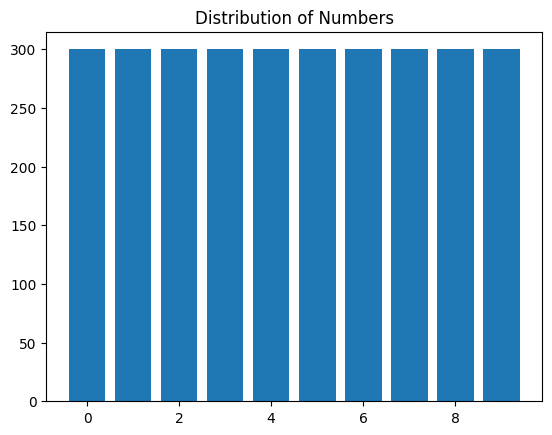

In [30]:
number_data = data.groupby(by='number')['speaker'].count()
plt.bar(x=number_data.index, height=number_data.values)
plt.title("Distribution of Numbers")
plt.show()

### Define functions for reading and augmenting data

In [38]:
def decode_audio(audio_file_path):
    audio = tf.io.read_file(audio_file_path)
    audio, rate = tf.audio.decode_wav(contents=audio)
    # print(rate)
    return tf.squeeze(audio, axis=-1)

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    return spectrogram

def add_noise(waveform, noise_factor=0.005):
    noise = tf.random.normal(shape=tf.shape(waveform), mean=0.0, stddev=1.0)
    return waveform + noise_factor * noise

def time_stretch(waveform, rate=1.25):
    return tf.image.resize(waveform, (int(waveform.shape[0] / rate),waveform.shape[1]))

def normalize_spectrogram(spectrogram):
    mean = tf.math.reduce_mean(spectrogram)
    std = tf.math.reduce_std(spectrogram)
    return (spectrogram - mean) / std

### Read a sample of data and draw its spectogram

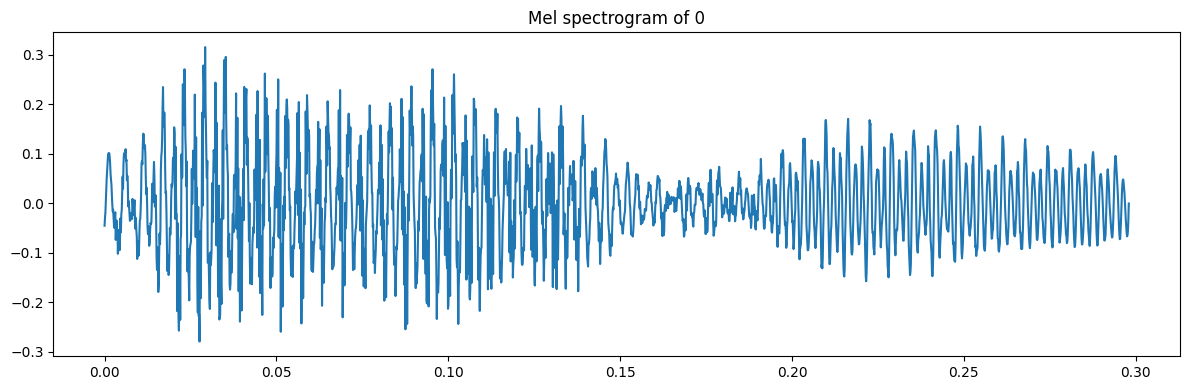

In [44]:
audio = decode_audio(data['path'].iloc[0])
Time = np.linspace( 
        0, # start 
        len(audio) / 8000, 
        num = len(audio) 
    ) 

plt.figure(figsize=(12, 4))
plt.plot(Time, audio)
plt.title('Mel spectrogram of {}'.format(data['number'].iloc[0]))
plt.tight_layout()
plt.show()

### read and convert all data into spectogram

In [45]:
data_list = []
target_list = []
for path, speaker, number in data.itertuples(index=False):
    audio = decode_audio(path)
    audio = get_spectrogram(audio)
    audio = add_noise(audio)
    audio = time_stretch(audio)
    audio = normalize_spectrogram(audio)
    data_list.append(audio)
    target_list.append(number)

In [46]:
print(len(data_list), len(target_list))
print(data_list[0].shape, data_list[1].shape)

3000 3000
(13, 129, 1) (28, 129, 1)


### Add padding to make all tenseros having equal len

In [47]:
def pad_tensor(tensor, target_size):
    padding = target_size - tf.shape(tensor)[0]
    if padding > 0:
        tensor = tf.pad(tensor, [[0, padding], [0, 0], [0, 0]])
    return tensor

tensors = [tf.random.normal((1, 100, 64)), tf.random.normal((1, 80, 64)), tf.random.normal((1, 120, 64))]
max_size = max(tf.shape(t)[0] for t in data_list).numpy()
padded_tensors = [pad_tensor(t, max_size) for t in data_list]

In [49]:
padded_tensors[0].shape, padded_tensors[1].shape

(TensorShape([112, 129, 1]), TensorShape([112, 129, 1]))

### prepare data for using in model

In [50]:
padded_tensors = np.array(padded_tensors)
target_list = np.array(target_list)
target_list = tf.keras.utils.to_categorical(target_list)

In [51]:
padded_tensors.shape, target_list.shape

((3000, 112, 129, 1), (3000, 10))

In [52]:
X_train, X_test, y_train, y_test = train_test_split(padded_tensors, target_list, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(2400, 112, 129, 1) (600, 112, 129, 1) (2400, 10) (600, 10)


### Define our model

In [53]:
input_shape = X_train.shape[1:]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Reshape((-1, 128)),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [54]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model_history = model.fit(X_train,
                        y_train,
                        batch_size=512,
                        validation_data=(X_test,y_test),
                        epochs=64,
                        shuffle=False,
                        callbacks=[early_stopping]
                        )

Epoch 1/64
5/5 ━━━━━━━━━━━━━━━━━━━━ 68s 11s/step - accuracy: 0.1985 - loss: 2.2784 - val_accuracy: 0.3967 - val_loss: 2.1777
Epoch 2/64
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step - accuracy: 0.4122 - loss: 2.1410 - val_accuracy: 0.4433 - val_loss: 2.0306
Epoch 3/64
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.4815 - loss: 1.9841 - val_accuracy: 0.4933 - val_loss: 1.8639
Epoch 4/64
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.5369 - loss: 1.8051 - val_accuracy: 0.5567 - val_loss: 1.6707
Epoch 5/64
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.5954 - loss: 1.5984 - val_accuracy: 0.6450 - val_loss: 1.4466
Epoch 6/64
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 8s/step - accuracy: 0.6898 - loss: 1.3662 - val_accuracy: 0.7367 - val_loss: 1.2075
Epoch 7/64
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 8s/step - accuracy: 0.7524 - loss: 1.1281 - val_accuracy: 0.8017 - val_loss: 0.9839
Epoch 8/64
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.8039 - loss: 0.9158 - val_accuracy: 0.8333 - val_loss: 0.8081
Epoch 9

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

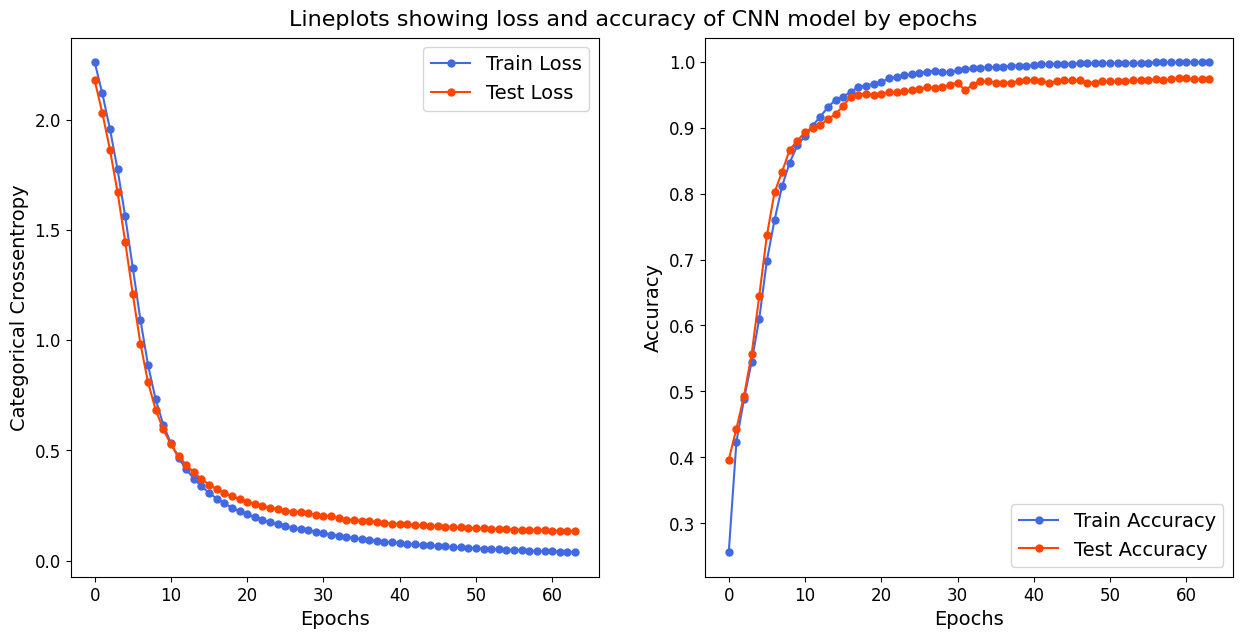

In [56]:
train_loss = model_history.history['loss']
test_loss = model_history.history['val_loss']
train_accuracy = model_history.history['accuracy']
test_accuracy = model_history.history['val_accuracy']

# Plotting a line chart to visualize the loss and accuracy values by epochs.
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

### Evaluate our model

In [58]:
test_audio = []
test_labels = []

for i in range(10):
    test_audio.append(X_test[i])
    test_labels.append(y_test[i])

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

predictions = model.predict(test_audio)

# Compare predictions with the labels
for i in range(10):
    print(f"Prediction: {np.argmax(predictions[i])}, Label: {test_labels[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
Prediction: 6, Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Prediction: 3, Label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Prediction: 6, Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Prediction: 0, Label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Prediction: 8, Label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Prediction: 3, Label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Prediction: 4, Label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Prediction: 7, Label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Prediction: 1, Label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Prediction: 8, Label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


### Save our model

In [59]:
model.save('speech_mnist_model.h5')